# Rydberg Atom Ion Interaction

Here we look at the interacton between a single ion and a Rydberg atom. More details regarding the theory can be found in [A. Duspayev et al., Phys. Rev. Research 3, 023114 (2021)](https://doi.org/10.1103/PhysRevResearch.3.023114) or [M. Deiß et al., Atoms 9, 2 (2021)](https://doi.org/10.3390/atoms9020034). The inernuclear axis is aligned with the z-direction and the interaction is expanded in multipolar terms. With this choice of coordinate system, the interaction potential is rotationally symmetric around the quantization axis and only states of same $m_J$ couple with each other, reducing the number of basis states.

We will reproduce here results shown in Fig. 2 in Phys. Rev. Research 3, 023114 (2021), demonstrating the influence of higher multipole order terms.

## Import the Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pairinteraction.real as pi

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

## Calculate Potential Curves

The ``SystemAtom`` class defines the Rydberg atom and the effect of the electric field of the ion can be included into the calculations. The charge of the ion can be passed with ``SystemAtom.set_ion_charge(value, unit)`` and the distance vector between the ion and the Rydberg core with ``SystemAtom.set_ion_distance_vector(vector, unit)``.

As an example we show how to calculate the energy of the Rydberg state for different internuclear distances and including a different number of multipole orders. Choosing a maximum multipole order of two is equivalent to calculating a StarkMap in a homogenious electric field.

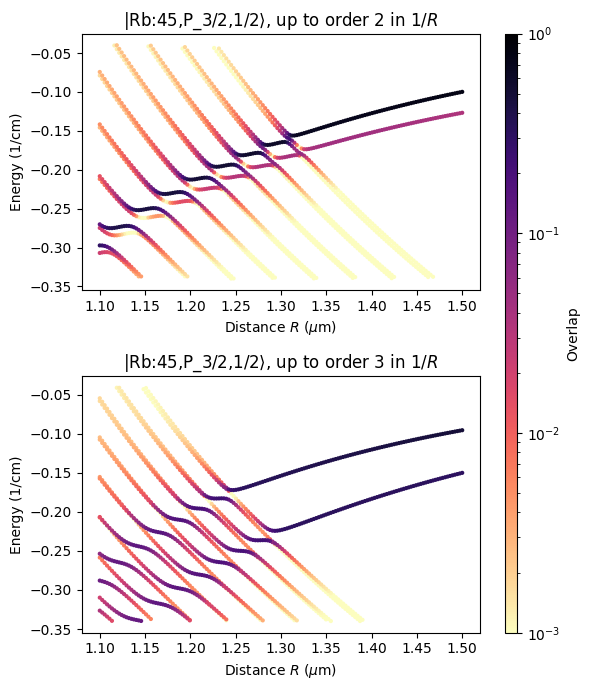

In [2]:
# Define the Rydberg state for which the interaction with the ion should be calculated
ket = pi.KetAtom("Rb", n=45, l=1, j=1.5, m=0.5)
energy = ket.get_energy("1/cm")

# Setup basis, considering states only with similar energy and principle quantum number.
# (if a high accuracy is required, the energy and principle quantum number ranges must be increased)
# Since the ion and Rydberg atom are placed on the z-axis, the magnetic momentum is conserved
basis = pi.BasisAtom(
    "Rb", n=(ket.n - 3, ket.n + 3), m=(ket.m, ket.m), energy=(energy - 4, energy + 4), energy_unit="1/cm"
)

fig = plt.figure(figsize=(6, 7))
axs = fig.subplots(2, 1)

# Setup system
# Define the maximum considered order of the multipole expansion.
# 2: monopole-dipole (scales like 1/R^2 with the distance R), 3: monopole-quadrupole (scales like 1/R^3), ...
distances = np.linspace(1.1, 1.5, 150)
for order, ax in zip([2, 3], axs):
    systems = [
        pi.SystemAtom(basis)
        .set_ion_charge(1, "e")
        .set_ion_interaction_order(order)
        .set_ion_distance_vector([0, 0, d], "um")
        for d in distances
    ]

    # Diagonalize the system
    pi.diagonalize(systems, diagonalizer="lapacke_evr", energy_range=(energy - 0.34, energy - 0.04), energy_unit="1/cm")

    # Get eigenenergies and overlaps
    list_eigenenergies = [system.get_eigenenergies(unit="1/cm") for system in systems]
    list_overlaps = [system.get_eigenbasis().get_overlaps(ket) for system in systems]
    list_distances = [d * np.ones_like(e) for d, e in zip(distances, list_eigenenergies)]

    # Sort so that the potential curves with largest overlap are plotted on top
    list_eigenenergies = np.hstack(list_eigenenergies)
    list_overlaps = np.hstack(list_overlaps)
    list_distances = np.hstack(list_distances)

    sorter = np.argsort(list_overlaps)
    list_distances = list_distances[sorter]
    list_eigenenergies = list_eigenenergies[sorter]
    list_overlaps = list_overlaps[sorter]

    # Plot the potential curves
    ax.set_title(rf"{ket}, up to order {order} in $1/R$")
    scat = ax.scatter(
        list_distances,
        list_eigenenergies - energy,
        c=list_overlaps,
        s=4,
        vmin=1e-3,
        vmax=1,
        norm="log",
        cmap="magma_r",
    )
    ax.set_xlabel(r"Distance $R$ ($\mu$m)")
    ax.set_ylabel("Energy (1/cm)")

fig.tight_layout()
fig.colorbar(scat, label="Overlap", ax=axs, aspect=50)
plt.show()